In [986]:
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from matplotlib import pyplot as plt
%matplotlib inline

In [987]:
# ucitavanje fajla i selektovanje bitki kao klase za predvidjanje
df = pd.read_csv('final.csv')

# selektovanje samo borbi kao dogadjaj i normalizovanje podataka
df_battles = df[(df['event_type'] == 'Battles')]

# pravimo korelacionu matricu da vidimo kako odredjeni faktori uticu na broj bitaka
# https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
corr = df_battles.corr('spearman')['event_count']
corr_year = corr.to_frame().drop(['event_count', 'year'])

# ako usrednjimo podakte drzava kroz godine, korelacija postaje jos izrazenija
df_battles_mean = df.groupby('country').mean()
df_battles_mean = df_battles_mean.drop('year', axis=1)

corr = df_battles_mean.corr('spearman')['event_count']
corr_country = corr.to_frame().drop('event_count')

new = pd.concat([corr_year, corr_country], keys=['Correlation for every year', 'Correlation for countries'], axis=1)
new.style.background_gradient(cmap='Greens')

,Correlation for every year,Correlation for countries
,event_count,event_count
iso,-0.111754,0.151092
population,0.514607,0.700916
imr,0.115965,-0.00690627
gdp,-0.198142,-0.0305849
polity,-0.0608851,-0.243076
fuel_export,0.194166,0.403242
precious_export,0.198196,0.301903
arrable_land,0.480581,0.634249
population_density,0.0570568,0.0770965


Izracunavanjem korelacija izmedju broja borbi i ostalih faktora moze se uociti postojanje neke zavisnosti. Za izracunavanje korelacije koriscen je Spearman-ov metod koji prati monotonost funkcije.

Prva kolona tabele prikazuje stepene korelacije za sve zemlje po godinama od 1997 do 2017 i njihove socio-ekonomske faktore po tim godinama. Preko korelacija moze se uociti da zemlje sa vecom populacijom imaju i veci broj borbi, takodje ono sto je zanimljivo jeste da postoji veliki stepen korelacije obradivog zemljista i broja borbi, odnosno da zemlje koje imaju dosta obradive povrsine imaju i dosta vise sukoba.

Druga kolona tabele prikazuje stepen korelacije kada se podaci grupisu po zemljama i uzme srednja vrednost socio-ekonomskih faktora za te zemlje. Ono sto se da primetiti jeste da su stepeni korelacije broja borbi sa populacijom i obradivim zemljistem porasli. Pored njih sada se mogu i izdvojiti jos izvoz nafte kao i izvoz primarnih dobara.

Takodje iz obe tabele se moze zakljuciti da je stepen korelacije borbi i prosecnog broja godina skolovanja, bdp-a, rasta bdp-a minimalan.

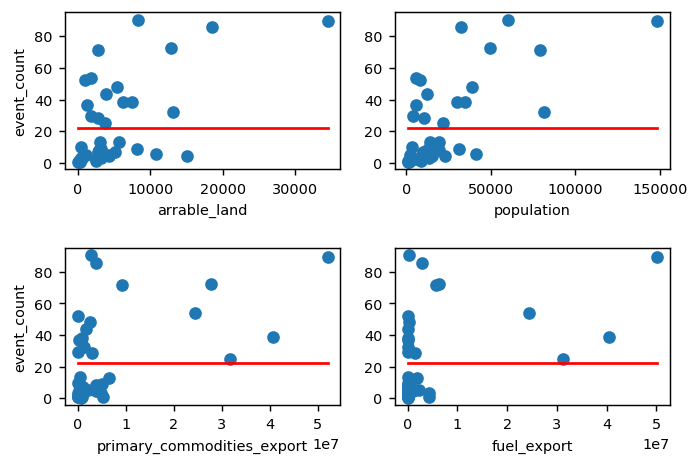

In [988]:
mean_battles = df_battles_mean.event_count.mean()

# plotovanje
params = {'axes.labelsize':8, 'axes.titlesize':8, 'figure.dpi':130, 'xtick.labelsize':8, 'ytick.labelsize':8}
plt.rcParams.update(params)
plt.subplots_adjust(hspace = 0.5)

plt.subplot(221)
plt.xlabel('arrable_land')
plt.ylabel('event_count')
plt.scatter(df_battles_mean.arrable_land, df_battles_mean.event_count)
plt.plot([df_battles_mean.arrable_land.min(), df_battles_mean.arrable_land.max()], [mean_battles, mean_battles], 'r')

plt.subplot(222)
plt.xlabel('population')
plt.scatter(df_battles_mean.population, df_battles_mean.event_count)
plt.plot([df_battles_mean.population.min(), df_battles_mean.population.max()], [mean_battles, mean_battles], 'r')

plt.subplot(223)
plt.xlabel('primary_commodities_export')
plt.ylabel('event_count')
plt.scatter(df_battles_mean.primary_commodities_export, df_battles_mean.event_count)
plt.plot([df_battles_mean.primary_commodities_export.min(), df_battles_mean.primary_commodities_export.max()], [mean_battles, mean_battles], 'r')

plt.subplot(224)
plt.xlabel('fuel_export')
plt.scatter(df_battles_mean.fuel_export, df_battles_mean.event_count)
plt.plot([df_battles_mean.fuel_export.min(), df_battles_mean.fuel_export.max()], [mean_battles, mean_battles], 'r')

print()

Prikazani su grafici broja borbi sa faktorima koji su imali najvecu korelaciju. Na svakom grafiku dodata je crvena linija koja predstavlja srednji broj bitaka za celu Afriku.

Sa grafika se moze videti da stvarno kako raste populacija raste i broj sukoba.
Takodje treba primetiti da sve zemlje koje su bogate naftom imaju veci broj sukoba nego prosek, ista je situacija i sa zemljama koje imaju veliki izvoz primarnih sirovina.

Total number of countries above mean export:  16 
Countries that are above mean export:  Algeria, Angola, Botswana, Burkina Faso, Democratic Republic of Congo, Egypt, Gabon, Ghana, Libya, Mali, Namibia, Nigeria, Republic of Congo, South Africa, Sudan, Tanzania

Total number of countries under mean export:  28 
Countries that are under mean export:  Burundi, Central African Republic, Chad, Benin, Ethiopia, Eritrea, Djibouti, Gambia, Guinea, Ivory Coast, Kenya, Lesotho, Liberia, Madagascar, Malawi, Mauritania, Morocco, Niger, Guinea-Bissau, Rwanda, Senegal, Sierra Leone, Zimbabwe, eSwatini, Togo, Tunisia, Uganda, Zambia


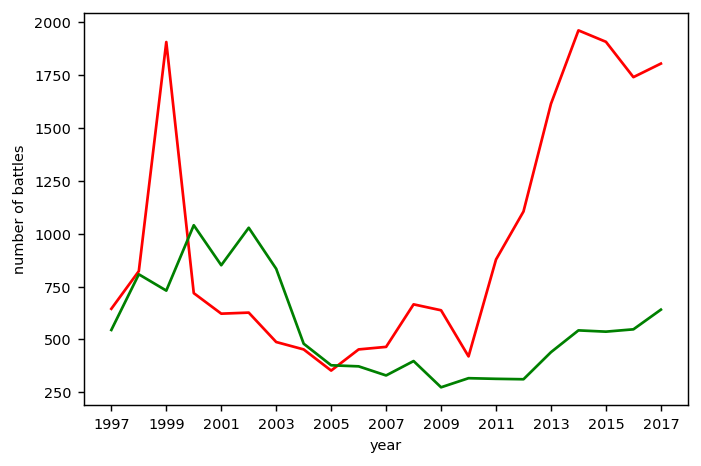

In [989]:
# nadju se srednje vrednosti svih exporta
mean_precious_export = df_battles_mean.precious_export.mean()
mean_fuel_export = df_battles_mean.fuel_export.mean()
# mean_primary_commodities_export = df_battles_mean.primary_commodities_export.mean()

# nadju se zemlje koje imaju vise od neke od srednjih vrednosti
df_above_export_mean = df_battles_mean[(df_battles_mean.precious_export > mean_precious_export) | (df_battles_mean.fuel_export > mean_fuel_export)].reset_index()
above = df_above_export_mean.country.unique()
df_above_export_mean = df_battles[(df_battles.country.isin(above))].groupby('year').sum().reset_index()


# nadju se zemlje koje imaju manje od neke od srednjih vrednosti
df_under_export_mean = df_battles_mean[(df_battles_mean.precious_export <= mean_precious_export) & (df_battles_mean.fuel_export <= mean_fuel_export)].reset_index()
df_under_export_mean = df_battles[(~df_battles.country.isin(above))].groupby('year').sum().reset_index()
under = df_battles[(~df_battles.country.isin(above))].country.unique()

plt.xlabel('year')
plt.ylabel('number of battles')
plt.xticks(np.arange(1997, 2018, 2))
plt.plot(df_above_export_mean.year, df_above_export_mean.event_count, 'r')
plt.plot(df_under_export_mean.year, df_under_export_mean.event_count, 'g')

print( 'Total number of countries above mean export: ', above.size, '\nCountries that are above mean export: ', ', '.join(above))
print( '\nTotal number of countries under mean export: ', under.size, '\nCountries that are under mean export: ', ', '.join(under))

Prateci cinjenicu sa gornjih grafika da zemlje bogate naftom imaju veci broj sukoba od proseka, odlucili smo da izracunamo prosecan izvoz nafte i prosecan izvoz vrednih metala i dragog kanmenja. Kako smo izracunali ova dva proseka zemlje smo podelili u dve grupe, prva grupa je sacinjena od zemlja koje imaju izvoz veci od proseka a druga od zemalja koje imaju manji izvoz od proseka. Dobijeno je da 16 zemalja spada u prvu, a 28 u drugu grupu.

Na grafiku ispod je prikazan ukupan broj borbi po godinama. Crvenom linijom su predstavljene zemlje sa velikim izvozom, a zelenom sa malim. Jasno se vidi da zemlje bogate naftom ili dragim kamenjem imaju dosta veci broj sukoba po godinama, a i sveukupno, sto ukazuje da bogatstvo zemlje ovim prirodnim resursima moze da bude pokazatelj za broj borbi.

Na grafiku takodje vidimo 2 nagla skoka, prvi je 1998 i tada je poceo Drugi konganski rat (Veliki rat Afrike). A drugi je oko 2011 godine kada je poceo drzavni rat u Libiji. Libije je u top 10 zemalja po zalihama nafete u svetu.

### Priprema podataka za predikciju

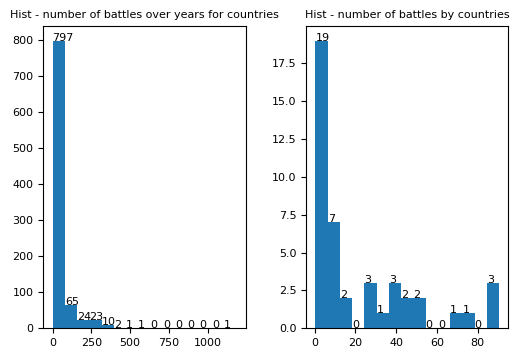

In [990]:
# gledanje distribucije broja borbi preko histograma
params = {'axes.labelsize':8, 'axes.titlesize':8, 'figure.dpi':100, 'xtick.labelsize':8, 'ytick.labelsize':8}
plt.rcParams.update(params)
plt.subplots_adjust(wspace = 0.3)
bins = 15

plt.subplot(121)
plt.title('Hist - number of battles over years for countries')
arr = plt.hist(df_battles.event_count, bins = bins)
for i in range(bins):
    plt.text(arr[1][i], arr[0][i], str(int(arr[0][i])), fontsize = 8)

plt.subplot(122)
plt.title('Hist - number of battles by countries')
arr = plt.hist(df_battles_mean.event_count, bins = bins)
for i in range(bins):
    plt.text(arr[1][i], arr[0][i], str(int(arr[0][i])), fontsize = 8)

Vidimo da tokom vecine godina jedna drzava obicno nije imala vise od 500 borbi, takodje vidimo da vecina drzava u proseku od 1997 do 2017 ima manje od 20 borbi.

Prema histogramima nasi podaci su jako lose balansirani jer vecina drzava godisnje ima jako mali broj borbi i ovo cemo moradi da izbalansiramo pre treniranja predikcionih modela. 

Prvo cemo podatke podeliti na 5 kategorija tako da svaka sadrzi 100+ clanova, pa cemo vrsiti upsamplovanje kategorija da svake kategorije bude 500.

In [991]:
# resavamo se svih NaN-ova i sklanjamo 2017 godinu koja ce nam biti validaciona
df_battles_data = df_battles[~df_battles.isnull().any(axis=1)]
df_battles_2017 = df_battles_data[(df_battles_data.year == 2017)]
df_battles_data = df_battles_data[(df_battles_data.year < 2017)]

b0 = df_battles_data[(df_battles_data.event_count == 0)]
b1to2 = df_battles_data[(df_battles_data.event_count > 0) & (df_battles_data.event_count <= 2)]
b3to10 = df_battles_data[(df_battles_data.event_count > 2) & (df_battles_data.event_count <= 10)]
b10to50 = df_battles_data[(df_battles_data.event_count > 10) & (df_battles_data.event_count <= 50)]
b50plus = df_battles_data[(df_battles_data.event_count > 50)]
print('Broj drzava koje su u nekoj godini imale: ')
print('\t0 borbi: ', b0.shape[0])
print('\t1-2 borbi: ', b1to2.shape[0])
print('\t3-10 borbi: ', b3to10.shape[0])
print('\t10-50 borbi: ', b10to50.shape[0])
print('\t50+ borbi: ', b50plus.shape[0])

# upsample
upsample_b0 = resample(b0, replace=True, n_samples=500, random_state=13)
upsample_b1to2 = resample(b1to2, replace=True, n_samples=500, random_state=13)
upsample_b3to10 = resample(b3to10, replace=True, n_samples=500, random_state=13)
upsample_b10to50 = resample(b10to50, replace=True, n_samples=500, random_state=13)
upsample_b50plus = resample(b50plus, replace=True, n_samples=500, random_state=13)

upsampled_data_whole = pd.concat([upsample_b0, upsample_b1to2, upsample_b3to10, upsample_b10to50, upsample_b50plus])

# izbacujemo nepotrebna obelezja
unneeded = ['event_count', 'iso3', 'event_type', 'country', 'iso']
upsampled_result = upsampled_data_whole.event_count
upsampled_data = upsampled_data_whole.drop(unneeded, axis=1)

# ne upsemplovani podaci za poredjenje rezultata
result = df_battles_data.event_count
data = df_battles_data.drop(unneeded, axis=1)

# test data
test_result = df_battles_2017.event_count
test_data = df_battles_2017.drop(unneeded, axis=1)

# racunanje tacnosti
def calculate_regresion_metrics(df_res, str_regressor):
    rmse = np.sqrt(np.sum(df_res.difference**2)/len(df_res.index))
    mae = np.sum(np.abs(df_res.difference))/len(df_res.index)
    print('Metrics for', str_regressor, ':\n \tRMSE: ', rmse ,'\n\tMAE: ', mae)
    num_over_estimated = np.array(df_res.difference[df_res.difference > 0]).size
    avg_over_estimated = np.array(df_res.difference[df_res.difference > 0]).mean()
    num_under_estimated = np.array(df_res.difference[df_res.difference <= 0]).size
    avg_under_estimated = np.array(df_res.difference[df_res.difference <+ 0]).mean()
    print('\n\tOverestimated: ', num_over_estimated, '\tAverage overestimation: ', avg_over_estimated)
    print('\tUnderestimated: ', num_under_estimated, '\tAverage understimation: ', avg_under_estimated)
    
def return_res_df(res):
    df_res = df_battles[['country', 'year', 'event_count']]
    df_res = df_res[(df_res.year == 2017)]
    df_res['predicted'] = res
    df_res['difference'] = df_res.predicted - df_res.event_count
    return df_res

Broj drzava koje su u nekoj godini imale: 
	0 borbi:  263
	1-2 borbi:  176
	3-10 borbi:  144
	10-50 borbi:  119
	50+ borbi:  154


#### Random Forest Regressor

In [992]:
regr = RandomForestRegressor(random_state = 13, n_estimators = 100, criterion = 'mae', verbose = 0)
regr.fit(upsampled_data, upsampled_result)
print('Regression tree constructed and fitted on upsampled data')

res = regr.predict(test_data)
df_res = return_res_df(res)
calculate_regresion_metrics(df_res, 'Random Forest Regressor')
df = df_res
print ()

regr.fit(data, result)
print('Regression tree constructed and fitted original data')
res = regr.predict(test_data)
df_res = return_res_df(res)
calculate_regresion_metrics(df_res, 'Random Forest Regressor')
print()

fi = regr.feature_importances_
f = test_data.columns
x = pd.Series(fi, index = f) 

df

Regression tree constructed and fitted on upsampled data
Metrics for Random Forest Regressor :
 	RMSE:  53.43529726985882 
	MAE:  26.595909090909096

	Overestimated:  28 	Average overestimation:  15.463035714285713
	Underestimated:  16 	Average understimation:  -46.07843749999999

Regression tree constructed and fitted original data
Metrics for Random Forest Regressor :
 	RMSE:  56.51464689473308 
	MAE:  28.696818181818184

	Overestimated:  30 	Average overestimation:  17.301
	Underestimated:  14 	Average understimation:  -53.116428571428564



,country,year,event_count,predicted,difference
120,Algeria,2017,45,73.230,28.230
246,Angola,2017,19,12.680,-6.320
372,Botswana,2017,0,3.030,3.030
498,Burundi,2017,23,19.420,-3.580
624,Central African Republic,2017,178,61.370,-116.630
750,Chad,2017,11,7.540,-3.460
876,Republic of Congo,2017,3,6.540,3.540
1002,Democratic Republic of Congo,2017,448,208.765,-239.235
1128,Benin,2017,3,2.990,-0.010
1254,Ethiopia,2017,157,119.700,-37.300


In [993]:
print('Sta izdvaja Random Forest kao najznacajnije faktore')
x.to_frame('importance').style.background_gradient(cmap='Greens')

Sta izdvaja Random Forest kao najznacajnije faktore


,importance
year,0.0505846
population,0.120128
imr,0.0937546
gdp,0.0856965
polity,0.0413597
fuel_export,0.054518
precious_export,0.0798709
arrable_land,0.131453
population_density,0.110157
primary_commodities_export,0.0480354


Vidimo da su dva najznacajniji faktori prema Random Forest algoritmu povrsina obradive zemlje, populacija i gustina naseljenosti. Znacaj populacaije i obradive zemlje se mogao videti i u korelacionoj matrici. Takodje vidimo da nema ni jedan skroz dominantan faktor i mozemo reci da bi za vecu tacnost verovatno trebalo sakupiti vise podataka i ukljuciti vise faktora. Na trecem mestu se nalazi i gustina naseljenosti, za koju skoro nije postojala nikakva korelacija sa brojem borbi.

Iz gresaka se moze zakljuciti da je najveci problem algoritma odrediti tacan broj velikih sukoba u prosku masi za oko 50. Sto se tice zemalja sa manjim brojem sukoba tu je znatno bolja situacija. Velika greska kod zemalja sa velikim brojem sukoba moze da bude posledica toga jer takvih zemalja ima dosta manje u podacima i vecina zemalja nema ima ispod 15 sukoba godisnje, te algoritan nije tacno naucio kako da se ponasa za ove redje zemlje.

Takodje je prisutno minimalno poboljsanje kod modela treniranog na upsamplovanim podacima.

#### Elastic Net

In [994]:
regr = ElasticNet(random_state = 13, l1_ratio = 1, alpha = 0.01, max_iter = 10000, normalize = True)
regr.fit(upsampled_data, upsampled_result)
print('Elastic Net constructed and fitted on upsampled data')

res = regr.predict(test_data)
df_res = return_res_df(res)
calculate_regresion_metrics(df_res, 'Elastic Net')
print()

regr.fit(data, result)
print('Elastic Net constructed and fitted original data')
res = regr.predict(test_data)
df_res = return_res_df(res)
calculate_regresion_metrics(df_res, 'Elastic Net')

fi = regr.coef_
f = test_data.columns
x = pd.Series(fi, index = f) 
print('Sta izdvaja Elastic Net kao najznacajnije faktore')
x.to_frame('importance').style.background_gradient(cmap='Greens')

Elastic Net constructed and fitted on upsampled data
Metrics for Elastic Net :
 	RMSE:  84.11000353890321 
	MAE:  50.734504229539354

	Overestimated:  31 	Average overestimation:  26.906451456701173
	Underestimated:  13 	Average understimation:  -107.55524545707655

Elastic Net constructed and fitted original data
Metrics for Elastic Net :
 	RMSE:  80.616003322622 
	MAE:  46.51541326599929

	Overestimated:  29 	Average overestimation:  22.414728057021453
	Underestimated:  15 	Average understimation:  -93.11007133668978
Sta izdvaja Elastic Net kao najznacajnije faktore


,importance
year,1.66089
population,0.0011133
imr,0.541078
gdp,-0
polity,-1.01448
fuel_export,1.91544e-06
precious_export,1.76938e-06
arrable_land,0.000341259
population_density,-0.0681976
primary_commodities_export,-1.99326e-06


Elastic net daje dosta losije rezultate nego Random Forest Regressor, parametre koje izdvaja kao najbitnije su prosek godina skolovanja i godina... sto je u potpunoj suprotnosti sa Random Forest Regressor-om i analizom korelacione matrice.

Pored toga promene parametara Elastic Net modela procene postaju losije i koeficijenti se menjaju drasticno, ovo je najbolja kombinacija koju sam pronasao za ove podatke. Takodje Elastic Net prema rezultatima radi bolje bez upsamplovanja podataka.

In [995]:
# bins = [-1, 0.9, 2, 10, 50, np.inf]
# names = ['0', '1-2', '2-10', '10-50', '50+']
bins = [-1, 1, 5, np.inf]
names = ['0-1', '2-5', '5+']
unneeded = ['event_count', 'iso3', 'event_type', 'country', 'event_count_categorical', 'iso']

# resavamo se svih NaN-ova i sklanjamo 2017 godinu koja ce nam biti validaciona
df_battles_data = df_battles[~df_battles.isnull().any(axis=1)].copy()
df_battles_data['event_count_categorical'] = pd.cut(df_battles_data.event_count, bins, labels=names, right=True)
df_battles_2017 = df_battles_data[(df_battles_data.year == 2017)]
df_battles_data = df_battles_data[(df_battles_data.year < 2017)]

b0to1 = df_battles_data[(df_battles_data.event_count >= 0) & (df_battles_data.event_count <= 1)]
b2to5 = df_battles_data[(df_battles_data.event_count > 1) & (df_battles_data.event_count <= 5)]
b5plus = df_battles_data[(df_battles_data.event_count > 5)]
print('Broj drzava koje su u nekoj godini imale: ')
print('\t0-1 borbi: ', b0to1.shape[0])
print('\t2-5 borbi: ', b2to5.shape[0])
print('\t3+ borbi: ', b5plus.shape[0])

# upsamplovani train skup
upsampled_data_whole['event_count_categorical'] = pd.cut(upsampled_data_whole.event_count, bins, labels=names, right=True)
upsampled_result = upsampled_data_whole.event_count_categorical
upsampled_data = upsampled_data_whole.drop(unneeded, axis=1)

# ne upsemplovani podaci za poredjenje rezultata
result = df_battles_data.event_count_categorical
data = df_battles_data.drop(unneeded, axis=1)

# test data
test_result = df_battles_2017.event_count_categorical
test_data = df_battles_2017.drop(unneeded, axis=1)

def return_res_df(res, valid_class):
    df_res = df_battles[['country', 'year', 'event_count']]
    df_res = df_res[(df_res.year == 2017)]
    df_res['valid_class'] = valid_class
    df_res['predicted'] = res
    return df_res

def calculate_clasification_metrics(df_res):
    print('Accuracy score: ', accuracy_score(df_res.valid_class, df_res.predicted))
    print('Precision score: ', precision_score(df_res.valid_class, df_res.predicted, average='macro'))
    print('Recall score: ', recall_score(df_res.valid_class, df_res.predicted, average='macro'))
    print('F1 score: ', f1_score(df_res.valid_class, df_res.predicted, average='macro'))
    print('Precision score by class: ', precision_score(df_res.valid_class, df_res.predicted, average=None))
    print('Recall score by class: ', recall_score(df_res.valid_class, df_res.predicted, average=None))
    

Broj drzava koje su u nekoj godini imale: 
	0-1 borbi:  375
	2-5 borbi:  150
	3+ borbi:  331


#### Random Forest Classifier

In [996]:
clf = RandomForestClassifier(random_state=13, n_estimators = 1000, criterion = 'entropy')
clf.fit(upsampled_data, upsampled_result.str.get_dummies())
print('Classification tree constructed and fitted on upsampled data')

res = clf.predict(test_data)
index = np.argmax(res, axis = 1)
res = [names[x] for x in index]
res = return_res_df(res, test_result)

fi = clf.feature_importances_
f = test_data.columns
x = pd.Series(fi, index = f)

calculate_clasification_metrics(res)
res

Classification tree constructed and fitted on upsampled data
Accuracy score:  0.7954545454545454
Precision score:  0.7218337218337219
Recall score:  0.7196969696969697
F1 score:  0.7122257053291535
Precision score by class:  [0.92307692 0.33333333 0.90909091]
Recall score by class:  [0.75       0.5        0.90909091]


,country,year,event_count,valid_class,predicted
120,Algeria,2017,45,5+,5+
246,Angola,2017,19,5+,5+
372,Botswana,2017,0,0-1,0-1
498,Burundi,2017,23,5+,5+
624,Central African Republic,2017,178,5+,5+
750,Chad,2017,11,5+,2-5
876,Republic of Congo,2017,3,2-5,5+
1002,Democratic Republic of Congo,2017,448,5+,5+
1128,Benin,2017,3,2-5,2-5
1254,Ethiopia,2017,157,5+,5+


In [997]:
print('Sta izdvaja Random Forest Classifier kao najznacajnije faktore')
x.to_frame('importance').style.background_gradient(cmap='Greens')

Sta izdvaja Random Forest Classifier kao najznacajnije faktore


,importance
year,0.0491248
population,0.133946
imr,0.0520655
gdp,0.0866328
polity,0.0541345
fuel_export,0.0791615
precious_export,0.0792131
arrable_land,0.111357
population_density,0.0839084
primary_commodities_export,0.0706448


Podelili smo zemlje u tri klase prema borju brorbi, u prvu klasu spadaju zemlje koje imaju od 0 do 1 borbe, drugu kasu spadaju zemlje koje imaju od 2 do 5 borbi i u trecu klasu spadaju zemlje koje imaju preko 5 borbi. Ovo smo uradili jer nije preterano bitno da li ce zemlja imati 50 ili 52 borbe, cinjenica je da je ta zemlja opasna i nestabilna. Takodje ako se u zemlji deo 0 ili 1 borba moze se smatrati da je zemlja poprilicno mirna i stabilna. Hteli smo da vidimo da li ce ovakav proces klasifikacije dati bolje rezultate od regresije i da li je ovo laksi problem za predvidjanje.

Ono sto primecujemo jeste da i Random Forest Calssifier kao najbitnije parametre uzima velicinu populacije i kolicinu obradivog zemljista. Rezultati pokazuju da je za 2017 godinu preko 70% drzava je dobro klasifikovano po svim merama koje smo koristili (Accuracy, Precision, Recall, F1). I ono sto je dobro jeste da za zemlje koje imaju preko 5 borbi su u vise 90% dobro klasifikovane, tako da algoritam dobro izdvaja najkriticnije zemlje.

In [998]:
gnb = GaussianNB()
gnb = gnb.fit(upsampled_data, upsampled_result)
res = gnb.predict(test_data)
res = return_res_df(res, test_result)

fi = clf.feature_importances_
f = test_data.columns
x = pd.Series(fi, index = f)

calculate_clasification_metrics(res)
res

Accuracy score:  0.6363636363636364
Precision score:  0.6005747126436781
Recall score:  0.5555555555555556
F1 score:  0.526797385620915
Precision score by class:  [0.55172414 0.33333333 0.91666667]
Recall score by class:  [1.         0.16666667 0.5       ]


,country,year,event_count,valid_class,predicted
120,Algeria,2017,45,5+,5+
246,Angola,2017,19,5+,5+
372,Botswana,2017,0,0-1,0-1
498,Burundi,2017,23,5+,0-1
624,Central African Republic,2017,178,5+,0-1
750,Chad,2017,11,5+,0-1
876,Republic of Congo,2017,3,2-5,0-1
1002,Democratic Republic of Congo,2017,448,5+,5+
1128,Benin,2017,3,2-5,0-1
1254,Ethiopia,2017,157,5+,5+


In [999]:
print('Sta izdvaja Naive Bayes Classifier kao najznacajnije faktore')
x.to_frame('importance').style.background_gradient(cmap='Greens')

Sta izdvaja Naive Bayes Classifier kao najznacajnije faktore


,importance
year,0.0491248
population,0.133946
imr,0.0520655
gdp,0.0866328
polity,0.0541345
fuel_export,0.0791615
precious_export,0.0792131
arrable_land,0.111357
population_density,0.0839084
primary_commodities_export,0.0706448


Pored Random Forest Classifier-a pokusali smo i sa Naive Bayes Classifier-om, njegovi rezultati su losiju u odnosu na Random Forest po svim merilima, no ono sto je zanimljivo jeste da je i Naive Bayes izdvojio velicinu populacije i kolicinu obradivog zemljista kao najznacajnije parametre.